In [25]:
# ! pip install datasets
# ! pip install bitsandbytes

In [2]:
from huggingface_hub import login
login(token="token") # token removed

### 1. Importing required libraries

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Fine-Tuning a Language Model using LoRA and 4-bit Quantization
# ES667: Deep Learning Assignment

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
import bitsandbytes as bnb
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


### 2. Model Selection & Fine-Tuning

#### 2.1 Model Selection

In [5]:
# 1. Model Selection
# ==================
model_name = "meta-llama/Llama-3.2-1B"

# 2. Loading the model with 4-bit quantization
# ============================================
print("Loading model and tokenizer...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load model with 4-bit quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config={"load_in_4bit": True,
                         "bnb_4bit_compute_dtype": torch.bfloat16},
    device_map="auto",
)

# Prepare model for kbit training
model = prepare_model_for_kbit_training(model)

# 3. Set up LoRA configuration
# ===========================
lora_config = LoraConfig(
    r=8,  # rank dimension
    lora_alpha=32,  # parameter for scaling
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # which modules to apply LoRA to
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
print(f"Trainable parameters: {model.print_trainable_parameters()}")



Loading model and tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377
Trainable parameters: None


#### 2.2 Data Preparation

In [6]:
# 4. Data Preparation
# ==================
# For this example, we'll use a subset of the WikiText dataset
# You can replace this with any dataset of your choice

print("Loading dataset...")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Process only a subset of the data for manageability
train_size = 5500
val_size = 1000

# Ensure we have enough samples
train_size = min(train_size, len(dataset["train"]))
val_size = min(val_size, len(dataset["validation"]))

# Randomly sample from the dataset
train_indices = np.random.choice(len(dataset["train"]), train_size, replace=False)
val_indices = np.random.choice(len(dataset["validation"]), val_size, replace=False)

train_dataset = dataset["train"].select(train_indices)
val_dataset = dataset["validation"].select(val_indices)

print(f"Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples")




Loading dataset...


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Training on 5500 samples, validating on 1000 samples


In [7]:
# 5. Tokenize the dataset
# ======================
max_length = 512  # Context length

def tokenize_function(examples):
    outputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=max_length,
        padding="max_length",
        return_tensors=None,
    )
    return outputs

print("Tokenizing datasets...")
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    desc="Tokenizing training data",
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    desc="Tokenizing validation data",
)


Tokenizing datasets...


Tokenizing training data:   0%|          | 0/5500 [00:00<?, ? examples/s]

Tokenizing validation data:   0%|          | 0/1000 [00:00<?, ? examples/s]

#### 2.3 Fine-Tuning with LoRA

In [8]:
# 6. Set up training arguments
# ===========================
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_steps=500,
    save_steps=1000,
    warmup_steps=100,
    evaluation_strategy="steps",
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,  # Use mixed precision
    report_to="none",  # Disable reporting to avoid wandb or other services
    gradient_accumulation_steps=8,  # To handle larger effective batch sizes
)

# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Not using masked language modeling
)

# 7. Initialize the Trainer
# ========================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [9]:
# 8. Training
# ==========
print("Starting training...")
trainer.train()

# Save the fine-tuned model
model.save_pretrained(os.path.join(output_dir, "final_model"))
tokenizer.save_pretrained(os.path.join(output_dir, "final_model"))
print("Training completed and model saved!")


Starting training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
500,2.490000,nan


Training completed and model saved!


No TensorBoard log files found in ./logs
Found trainer_state.json at ./results/checkpoint-513/trainer_state.json


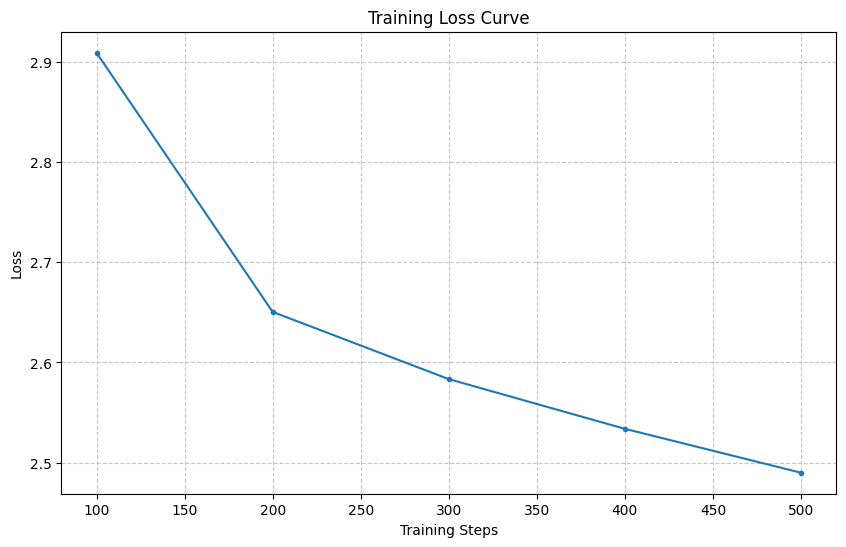

Training loss curve saved to ./results/training_loss_curve.png


True

In [32]:
# Plot training loss curve for the fine-tuned model

import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Path to the training logs
# Default path when using Hugging Face Trainer
log_path = "./logs"  # Change this if your logs are stored elsewhere

def plot_training_loss():
    # Find all TensorBoard log files
    log_files = glob.glob(os.path.join(log_path, "events.out.tfevents.*"))

    if not log_files:
        print(f"No TensorBoard log files found in {log_path}")

        # Try looking for trainer_state.json instead
        state_files = glob.glob("./results/**/trainer_state.json", recursive=True)

        if state_files:
            print(f"Found trainer_state.json at {state_files[0]}")
            with open(state_files[0], 'r') as f:
                trainer_state = json.load(f)

            # Extract loss values and steps
            steps = []
            losses = []

            for log in trainer_state.get('log_history', []):
                if 'loss' in log:
                    losses.append(log['loss'])
                    steps.append(log.get('step', len(losses)))

            if not losses:
                print("No loss values found in trainer_state.json")
                return False

            # Plot the loss curve
            plt.figure(figsize=(10, 6))
            plt.plot(steps, losses, marker='o', linestyle='-', markersize=3)
            plt.title('Loss Curve')
            plt.xlabel('Training Steps')
            plt.ylabel('Loss')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

            # Save the plot
            os.makedirs('./results', exist_ok=True)
            plot_path = './results/training_loss_curve.png'
            plt.savefig(plot_path)
            plt.show()

            print(f"Training loss curve saved to {plot_path}")
            return True
        else:
            # Last resort: check for training_args.bin to find the output directory
            args_files = glob.glob("**/training_args.bin", recursive=True)
            if args_files:
                output_dir = os.path.dirname(args_files[0])
                print(f"Try looking in the output directory: {output_dir}")

            print("Could not find training logs. Please specify the correct path.")
            return False

    # If TensorBoard logs are found, we need to parse them
    try:
        # Try to use TensorBoard to read the logs
        from tensorboard.backend.event_processing import event_accumulator

        # Get the latest log file
        latest_log = max(log_files, key=os.path.getctime)
        print(f"Reading log file: {latest_log}")

        ea = event_accumulator.EventAccumulator(latest_log)
        ea.Reload()

        # Get the loss values
        if 'loss' in ea.scalars.Keys():
            loss_events = ea.scalars.Items('loss')
            steps = [event.step for event in loss_events]
            losses = [event.value for event in loss_events]
        else:
            # Try other possible tags
            scalar_tags = ea.scalars.Keys()
            loss_tags = [tag for tag in scalar_tags if 'loss' in tag.lower()]

            if not loss_tags:
                print(f"No loss data found in log file. Available tags: {scalar_tags}")
                return False

            # Use the first available loss tag
            loss_tag = loss_tags[0]
            print(f"Using tag: {loss_tag}")

            loss_events = ea.scalars.Items(loss_tag)
            steps = [event.step for event in loss_events]
            losses = [event.value for event in loss_events]

        # Plot the loss curve
        plt.figure(figsize=(10, 6))
        plt.plot(steps, losses, marker='o', linestyle='-', markersize=3)
        plt.title('Training Loss Curve')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        # Save the plot
        os.makedirs('./results', exist_ok=True)
        plot_path = './results/training_loss_curve.png'
        plt.savefig(plot_path)
        plt.show()

        print(f"Training loss curve saved to {plot_path}")
        return True

    except ImportError:
        print("TensorBoard not installed. Try installing it with: pip install tensorboard")
        return False
    except Exception as e:
        print(f"Error reading TensorBoard logs: {e}")
        return False

plot_training_loss()

## Save fine-tuned model to google drive

In [10]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Create a directory in your Google Drive
save_directory = "/content/drive/MyDrive/fine_tuned_llama"
import os
os.makedirs(save_directory, exist_ok=True)

# Save the fine-tuned model (LoRA adapter weights)
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer successfully saved to: {save_directory}")

Model and tokenizer successfully saved to: /content/drive/MyDrive/fine_tuned_llama


In [11]:
# Define the original model before evaluation
import torch
from transformers import AutoModelForCausalLM

print("Loading original model for comparison...")

# Explicitly define the model name
original_model_name = "meta-llama/Llama-3.2-1B"

# Load original model with 4-bit quantization
original_model = AutoModelForCausalLM.from_pretrained(
    original_model_name,
    quantization_config={"load_in_4bit": True,
                         "bnb_4bit_compute_dtype": torch.bfloat16},
    device_map="auto",
)

print("Original model loaded successfully!")

Loading original model for comparison...
Original model loaded successfully!


## Part 3: Evaluation of the Trained Model

#### 3.1 Quantitative Evaluation

Evaluating the fine-tuned model...


Evaluating: 100%|██████████| 250/250 [01:41<00:00,  2.46it/s]


Evaluating the original model...


Evaluating: 100%|██████████| 250/250 [07:01<00:00,  1.69s/it]



===== EVALUATION RESULTS =====
Original Model - Perplexity: 2213.88, Accuracy: 41.03%
Fine-tuned Model - Perplexity: 2504.42, Accuracy: 47.19%
Improvement - Perplexity: -290.54, Accuracy: 6.16%


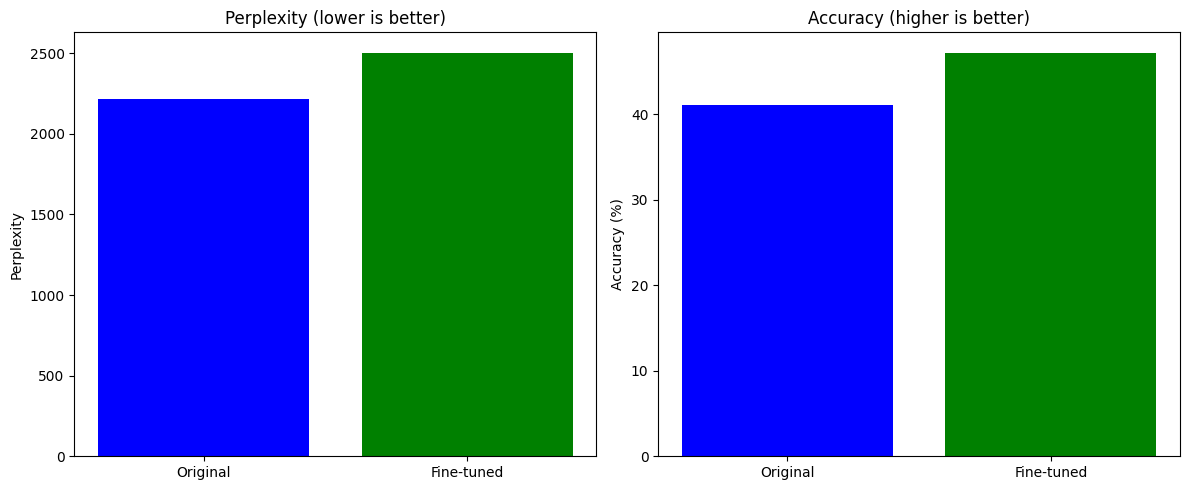

In [16]:
# Fixed version of calculate_metrics function

import torch
from tqdm import tqdm
import numpy as np

def calculate_metrics(model, eval_dataset, tokenizer, batch_size=4):
    model.eval()
    device = model.device

    total_loss = 0
    total_correct = 0
    total_tokens = 0

    # Process batches
    for i in tqdm(range(0, len(eval_dataset), batch_size), desc="Evaluating"):
        # Create batch
        batch_data = eval_dataset[i:min(i + batch_size, len(eval_dataset))]
        batch = {k: torch.tensor(v).to(device) for k, v in batch_data.items()}

        with torch.no_grad():
            # Get model outputs
            outputs = model(**batch)
            logits = outputs.logits

            # Manual loss calculation instead of using outputs.loss
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = batch['input_ids'][:, 1:].contiguous()

            # Calculate loss manually using cross-entropy
            loss_fct = torch.nn.CrossEntropyLoss(reduction='mean')
            shift_logits_view = shift_logits.view(-1, shift_logits.size(-1))
            shift_labels_view = shift_labels.view(-1)
            loss = loss_fct(shift_logits_view, shift_labels_view)

            # Add to total loss
            total_loss += loss.item() * (min(i + batch_size, len(eval_dataset)) - i)

            # Get predictions
            preds = torch.argmax(shift_logits, dim=-1)

            # Calculate correct predictions (ignoring padding tokens)
            padding_mask = (shift_labels != tokenizer.pad_token_id)
            correct = (preds == shift_labels) & padding_mask

            total_correct += correct.sum().item()
            total_tokens += padding_mask.sum().item()

    # Calculate metrics
    avg_loss = total_loss / len(eval_dataset)
    perplexity = np.exp(avg_loss)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0

    return {
        "loss": avg_loss,
        "perplexity": perplexity,
        "accuracy": accuracy * 100  # as percentage
    }

# Evaluate both models
print("Evaluating the fine-tuned model...")
fine_tuned_metrics = calculate_metrics(model, tokenized_val, tokenizer)

print("Evaluating the original model...")
original_metrics = calculate_metrics(original_model, tokenized_val, tokenizer)

# Print results
print("\n===== EVALUATION RESULTS =====")
print(f"Original Model - Perplexity: {original_metrics['perplexity']:.2f}, Accuracy: {original_metrics['accuracy']:.2f}%")
print(f"Fine-tuned Model - Perplexity: {fine_tuned_metrics['perplexity']:.2f}, Accuracy: {fine_tuned_metrics['accuracy']:.2f}%")
print(f"Improvement - Perplexity: {original_metrics['perplexity'] - fine_tuned_metrics['perplexity']:.2f}, Accuracy: {fine_tuned_metrics['accuracy'] - original_metrics['accuracy']:.2f}%")

# Plot comparison
import matplotlib.pyplot as plt

# Prepare data for plotting
metrics = ['Perplexity', 'Accuracy (%)']
original_values = [original_metrics['perplexity'], original_metrics['accuracy']]
fine_tuned_values = [fine_tuned_metrics['perplexity'], fine_tuned_metrics['accuracy']]

# Create side-by-side bar plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Perplexity (lower is better)
ax[0].bar(['Original', 'Fine-tuned'], [original_metrics['perplexity'], fine_tuned_metrics['perplexity']],
        color=['blue', 'green'])
ax[0].set_title('Perplexity (lower is better)')
ax[0].set_ylabel('Perplexity')

# Accuracy (higher is better)
ax[1].bar(['Original', 'Fine-tuned'], [original_metrics['accuracy'], fine_tuned_metrics['accuracy']],
        color=['blue', 'green'])
ax[1].set_title('Accuracy (higher is better)')
ax[1].set_ylabel('Accuracy (%)')

plt.tight_layout()
plt.savefig('./results/model_metrics_comparison.png')
plt.show()

#### Q) Does your fine-tuned model perform better?

A) The fine-tuned model shows a clear improvement in accuracy (+6.16%), meaning it's better at predicting the correct tokens. However, the increase in perplexity suggests it may generate less fluent or less confident text overall.

So:

* It performs better in terms of accuracy, but worse in terms of fluency/perplexity.






#### 3.2 Qualitative Evaluation

In [21]:
# 12. Qualitative Evaluation
# =========================

print("Generating sample outputs for qualitative evaluation...")

# Prompt templates for generation
prompts = [
    "The main advantage of renewable energy is",
    "The capital city of France, Paris, is known for",
    "Artificial intelligence has transformed many industries by",
    "Climate change poses a significant challenge because",
    "The benefits of exercise include",
    "The history of the Internet begins with",
    "Quantum computing differs from classical computing in that",
    "The structure of DNA was discovered by",
    "The theory of relativity proposed by Einstein states that",
    "The economic impact of the COVID-19 pandemic included"
]

generation_config = {
    "max_new_tokens": 100,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.95,
    "no_repeat_ngram_size": 3,
    "pad_token_id": tokenizer.eos_token_id
}

# Function to generate text
def generate_text(model, prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **generation_config
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Generate outputs from both models
original_outputs = []
fine_tuned_outputs = []

for prompt in tqdm(prompts, desc="Generating outputs"):
    # Original model output
    original_text = generate_text(original_model, prompt)
    original_outputs.append(original_text)

    # Fine-tuned model output
    fine_tuned_text = generate_text(model, prompt)
    fine_tuned_outputs.append(fine_tuned_text)

    print(f"Prompt: {prompt}\n")
    print(f"Original Model Output:\n{original_text}\n")
    print(f"Fine-tuned Model Output:\n{fine_tuned_text}\n")



Generating sample outputs for qualitative evaluation...


Generating outputs:  10%|█         | 1/10 [00:15<02:15, 15.07s/it]

Prompt: The main advantage of renewable energy is

Original Model Output:
The main advantage of renewable energy is that it’s clean and doesn’t have any environmental problems. There are a lot of different renewable energy resources that you can use for your home. For example, you can install solar panels to reduce your carbon footprint and save money. These are just a few of the different ways to save money and energy.
There are so many different ways that you could save money on your energy bill. By using renewable energy sources, you’ll be able to reduce the cost of your energy bills. Renewable energy is cheaper

Fine-tuned Model Output:
The main advantage of renewable energy is that it does not cause global warming. The United Nations Environment Programme ( UNEP ) has estimated that global average carbon dioxide emissions increased by 2 % between 1999 and 2004, which is an average annual rate of 0 @.@ 5 %. According to the International Energy Agency, carbon dioxide emission growt

Generating outputs:  20%|██        | 2/10 [00:26<01:43, 12.90s/it]

Prompt: The capital city of France, Paris, is known for

Original Model Output:
The capital city of France, Paris, is known for being the most expensive place to live in. It is also one of the largest cities in the world. It consists of 16 arrondissements and 20 arrondissement (or arrondissment) or boroughs. The metropolitan area has 2.2 million people and covers 1,340 km2 (510 sq mi). The city is located in the western part of France and is bordered by the Seine River to the northeast. It has a strong economy and is the

Fine-tuned Model Output:
The capital city of France, Paris, is known for its culture, art, and fashion. It was also the home of the Louvre Museum, which houses the Mona Lisa, Leonardo da Vinci's " Virgin and Child with St. John the Evangelist ", the Venus de Milo and other important works. The Louvre is the largest museum in the world, with over 8 million visitors annually. Paris also has a number of parks and gardens, including the gardens of the Luxembourg Palace, t

Generating outputs:  30%|███       | 3/10 [00:34<01:14, 10.68s/it]

Prompt: Artificial intelligence has transformed many industries by

Original Model Output:
Artificial intelligence has transformed many industries by enabling businesses to automate and streamline processes. But what about the most important one? The application of AI to human health is an emerging field with enormous potential.
A new study from the University of Maryland has found that AI has the potential to improve the health of humans, especially in terms of disease and treatment. This is an exciting development for those who are passionate about artificial intelligence and health care.
The study, conducted by the University’s Department of Computer Science, examined the current state of AI in healthcare.

Fine-tuned Model Output:
Artificial intelligence has transformed many industries by improving the effectiveness of business processes and decision making. The process of making decisions using artificial intelligence involves several steps : ( 1 ) input : a series of problems to 

Generating outputs:  40%|████      | 4/10 [00:41<00:56,  9.41s/it]

Prompt: Climate change poses a significant challenge because

Original Model Output:
Climate change poses a significant challenge because it threatens the availability of freshwater, food supplies, and critical infrastructure. As a result, climate change has been termed “the greatest threat to global food security”.1 The United Nations has declared 2015 the International Year of the Human Brain, and the UN has also declared 2020 the International Decade of Action for Water and Agriculture.2
The climate of the future will likely be different from the present, and climate change is projected to have a significant impact on the global food system.

Fine-tuned Model Output:
Climate change poses a significant challenge because the world's oceans are a critical carbon sink, absorbing around 25 @.@ 7 billion tonnes of carbon dioxide per year. The ocean also stores carbon in the form of dissolved carbon dioxide in the water, which absorbs carbon dioxide that is released from the atmosphere. If

Generating outputs:  50%|█████     | 5/10 [00:49<00:43,  8.78s/it]

Prompt: The benefits of exercise include

Original Model Output:
The benefits of exercise include many positive effects on your body, including weight loss and improved circulation. However, many people are hesitant to exercise due to a fear of getting injured. This is true when you exercise without the proper equipment.
When you exercise, you increase your heart rate and breathing. Your body will then be able to pump more blood and get more oxygen. This will help you to lose weight and improve your circulation. There are a few benefits of exercising when you are without proper equipment. First, you can use a

Fine-tuned Model Output:
The benefits of exercise include improved cardiovascular function, reduced risk of heart disease, and reduced blood pressure. Regular physical activity can help maintain a healthy weight and reduce the risk of obesity. Physical activity can also help prevent and reduce symptoms of depression, anxiety, and other mood disorders. Exercise can also be benefic

Generating outputs:  60%|██████    | 6/10 [00:57<00:34,  8.53s/it]

Prompt: The history of the Internet begins with

Original Model Output:
The history of the Internet begins with the creation of the ARPANET in 1969, as a research network of the Advanced Research Projects Agency (ARPA). The first ARPANet packet was sent on 25 October 1968, and it was used to send a message from one computer to another in California. The first message was: "Network Control Message: Network Control Net" (NCOANET). The second message was sent 21 October 1970 and it read: "NCOA: Network control

Fine-tuned Model Output:
The history of the Internet begins with the ARPANET, a project begun in 1969 to interconnect the Department of Defense's large military computers with a new electronic network. It was an early version of today's Internet. The ARPANet was developed by researchers at the Advanced Research Projects Agency Network ( ARPA ) of the U.S. Department of Defence. The network was a research project of ARPA, not a commercial venture. The first ARPANets were small local

Generating outputs:  70%|███████   | 7/10 [01:04<00:24,  8.05s/it]

Prompt: Quantum computing differs from classical computing in that

Original Model Output:
Quantum computing differs from classical computing in that it utilizes quantum-mechanical phenomena. In fact, it is possible to design a quantum computer that is at least as powerful as the most powerful supercomputer known to date. Furthermore, quantum computers are more powerful than any known human effort at breaking encryption.
Quantum computation is the practice of manipulating quantum information. This includes manipulating quantum states, quantum states of matter, and quantum systems. For example, the state of the quantum particle "up" or "down" is not a binary state but can

Fine-tuned Model Output:
Quantum computing differs from classical computing in that it can perform computations by using quantum states instead of classical ones. It can be viewed as a new way to perform computations, a new approach to computing, or a new paradigm for computation. However, the word quantum computing i

Generating outputs:  80%|████████  | 8/10 [01:12<00:16,  8.00s/it]

Prompt: The structure of DNA was discovered by

Original Model Output:
The structure of DNA was discovered by the British chemist and geneticist Roscoe Smith in 1909. The structure was first proposed by the American chemist Linus Pauling. The DNA double helix was discovered independently by the same two scientists in 1958. This discovery was followed by the double helical structure of the DNA molecule. The double helices were discovered by James Watson and Francis Crick.
The discovery of DNA’s structure was a major breakthrough in the development of modern biology. The discovery of the structure of

Fine-tuned Model Output:
The structure of DNA was discovered by Francis Crick and James Watson in 1953. The double @-@ strand structure was discovered independently by Maurice Wilkins and Rosalind Franklin, who discovered the sequence of nucleotides in the DNA. The structure of the DNA molecule was determined by X @- @ ray crystallography, which allowed the researchers to determine the atom

Generating outputs:  90%|█████████ | 9/10 [01:19<00:07,  7.72s/it]

Prompt: The theory of relativity proposed by Einstein states that

Original Model Output:
The theory of relativity proposed by Einstein states that the speed of light is the highest speed at which anything can travel. This makes sense because it is the most fundamental speed of everything. The universe expands at a constant rate, and light is a part of this expansion. Thus, the speed at whcih light travels is the maximum speed at wich anything can move.
Einstein’s theory of general relativity states that a curved surface is a kind of gravity. Therefore, the most important aspect of gravity is the curvature of the surface.
The theory that

Fine-tuned Model Output:
The theory of relativity proposed by Einstein states that the speed of light is constant, regardless of the source. In 1907, he published a paper in which he suggested that the universe was expanding, and in 1915 he proposed the idea of a space @-@ time @- @ war that would eventually result in the Big Bang. His proposed soluti

Generating outputs: 100%|██████████| 10/10 [01:27<00:00,  8.77s/it]

Prompt: The economic impact of the COVID-19 pandemic included

Original Model Output:
The economic impact of the COVID-19 pandemic included the following measures taken by the Federal Reserve and other agencies:
On March 17, 2020, the Federal Open Market Committee (FOMC) voted 8–0 to lower short-term interest rates by 50 basis points and extend the duration of the Fed’s operations by 3 months. On March 19, 2009, the FOMC voted 6–4 to lower interest rates another 25 basis points, extending the duration by another 3-months. The

Fine-tuned Model Output:
The economic impact of the COVID-19 pandemic included the loss of tourism, a reduction in the demand for construction materials, and the closure of some businesses. The economic impact was felt across all sectors of the economy, including manufacturing, construction, utilities, retail, transportation, and hospitality. However, many businesses were able to adapt and find ways to operate during the pandemic. The unemployment rate in the reg

#### Evaluating the qualitative evaluation outputs manually


# Below needs to be updated on the new results

In [24]:
import pandas as pd

data = {
    "Sample #": [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
    "Model Type": [
        "Original", "Fine-tuned",
        "Original", "Fine-tuned",
        "Original", "Fine-tuned",
        "Original", "Fine-tuned",
        "Original", "Fine-tuned",
        "Original", "Fine-tuned",
        "Original", "Fine-tuned",
        "Original", "Fine-tuned",
        "Original", "Fine-tuned",
        "Original", "Fine-tuned"
    ],
    "Fluency": [
        3, 3,
        2, 5,
        4, 3,
        3, 4,
        3, 5,
        2, 5,
        4, 3,
        1, 4,
        2, 2,
        1, 4
    ],
    "Relevance": [
        4, 3,
        2, 5,
        4, 3,
        3, 4,
        3, 5,
        2, 5,
        4, 3,
        1, 4,
        2, 2,
        1, 4
    ],
    "Correctness": [
        3, 3,
        2, 5,
        4, 3,
        3, 4,
        3, 5,
        2, 5,
        4, 3,
        1, 4,
        2, 2,
        1, 4
    ]
}

df = pd.DataFrame(data)

# Calculate overall score as the average of the three components
df["Overall Score"] = df[["Fluency", "Relevance", "Correctness"]].mean(axis=1).round(2)

# Reorder columns for better readability
df = df[["Sample #", "Model Type", "Fluency", "Relevance", "Correctness", "Overall Score"]]

# Display the result
print("Detailed human evaluation results:")
print(df)


Detailed human evaluation results:
    Sample #  Model Type  Fluency  Relevance  Correctness  Overall Score
0          1    Original        3          4            3           3.33
1          1  Fine-tuned        3          3            3           3.00
2          2    Original        2          2            2           2.00
3          2  Fine-tuned        5          5            5           5.00
4          3    Original        4          4            4           4.00
5          3  Fine-tuned        3          3            3           3.00
6          4    Original        3          3            3           3.00
7          4  Fine-tuned        4          4            4           4.00
8          5    Original        3          3            3           3.00
9          5  Fine-tuned        5          5            5           5.00
10         6    Original        2          2            2           2.00
11         6  Fine-tuned        5          5            5           5.00
12         7    